In [9]:
import os
import sys
import umap

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
from matplotlib import cm

sys.path.insert(0, "..")
from utils import join_data, load_dataset, preprocess, get_dataset_names
from utils import DATASET_STRAIN_DICT, DATAPATH, RESULTSPATH, SEGMENTS

## Load data and preprocessing

In [10]:
CUTOFF=0

def load_all(dfnames: list):
    dfs = list()
    for dfname in dfnames:
        strain = DATASET_STRAIN_DICT[dfname]
        df = join_data(load_dataset(dfname))
        dfs.append(preprocess(strain, df, CUTOFF))
    return dfs

dfnames = get_dataset_names(cutoff=40)
dfs = load_all(dfnames)

normalize_counts = False
if normalize_counts:
    for df in dfs:
        df["NGS_norm"] = df["NGS_read_count"] / df["NGS_read_count"].max()
    col = "NGS_norm"
    filename = f"{CUTOFF}_all_norm.csv"
else:
    col = "NGS_read_count"
    filename = f"{CUTOFF}_all.csv"

result = pd.concat([df.set_index("key")[col] for df in dfs], axis=1)
result = result.fillna(0)
result.columns = dfnames

print(result)

               Alnaji2021  Pelz2021  Wang2023  Wang2020  Zhuravlev2020  \
key                                                                      
HA_25_1645            1.0       0.0       0.0       0.0            0.0   
HA_26_1507            2.0       0.0       0.0       0.0            0.0   
HA_26_1581            2.0       0.0       0.0       0.0            0.0   
HA_26_1609            1.0       0.0       0.0       0.0            0.0   
HA_27_1429            1.0       0.0       0.0       0.0            0.0   
...                   ...       ...       ...       ...            ...   
PB2_2224_2250         0.0       0.0       0.0       0.0            0.0   
PB2_2227_2296         0.0       0.0       0.0       0.0            0.0   
PB2_2245_2300         0.0       0.0       0.0       0.0            0.0   
PB2_2248_2327         0.0       0.0       0.0       0.0            0.0   
PB2_2302_2365         0.0       0.0       0.0       0.0            0.0   

               Alnaji2019_Cal07  Alna

In [11]:
remove_single_occurrences = True
if remove_single_occurrences:
    result["non-zero"] = result.apply(lambda row: (row != 0).sum(), axis=1).to_list()
    result = result[result["non-zero"] != 1]
    result.drop(columns=["non-zero"], inplace=True)
    filename = f"filtered_{filename}"

filepath = os.path.join(DATAPATH, "batch_effect_cache", filename)
if not os.path.isfile(filepath):
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_results = reducer.fit_transform(result)
    umap_df = pd.DataFrame(umap_results, columns=["UMAP1", "UMAP2"])

    umap_df["keys"] = result.index
    umap_df["non_zero_count"] = result.apply(lambda row: (row != 0).sum(), axis=1).to_list()
    umap_df.to_csv(filepath, index=False)
else:
    umap_df = pd.read_csv(filepath)

### Show the results of the UMAP in scatter plot

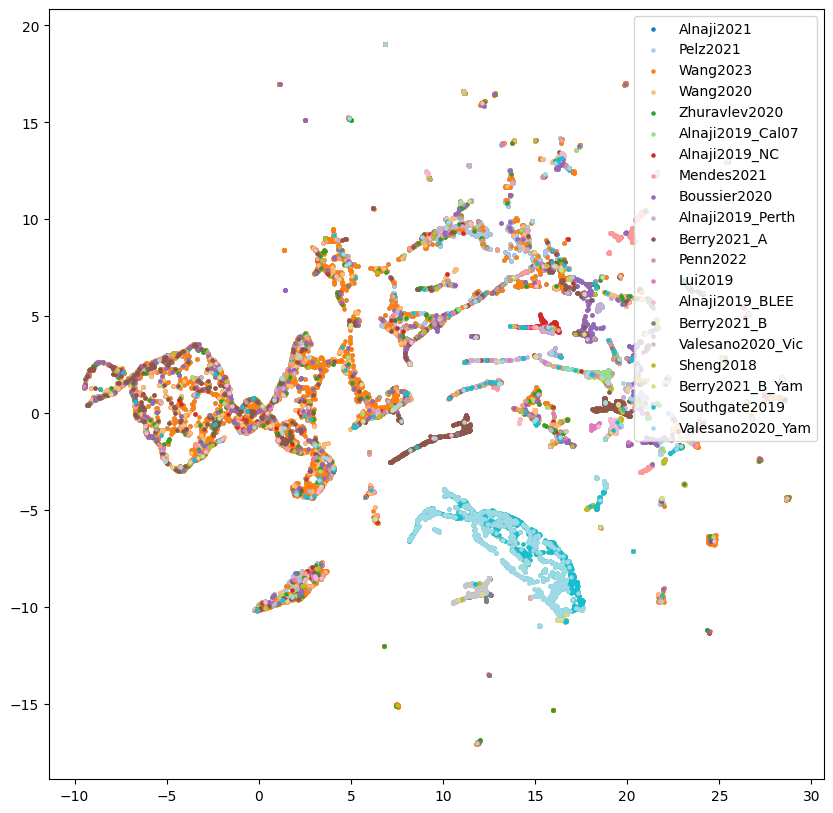

In [12]:
plt.figure(figsize=(10, 10))
colormap = cm.get_cmap("tab20")
colors = [colormap(i/20) for i in range(20)]

for i, (df, dfname) in enumerate(zip(dfs, dfnames)):
    keys = df["key"].to_list()
    t_df = umap_df[umap_df["keys"].isin(keys)]
    plt.scatter(t_df["UMAP1"], t_df["UMAP2"], label=dfname, s=5, alpha=1, color=colors[i])
    
plt.legend()
plt.show()

### check the strains of the data points

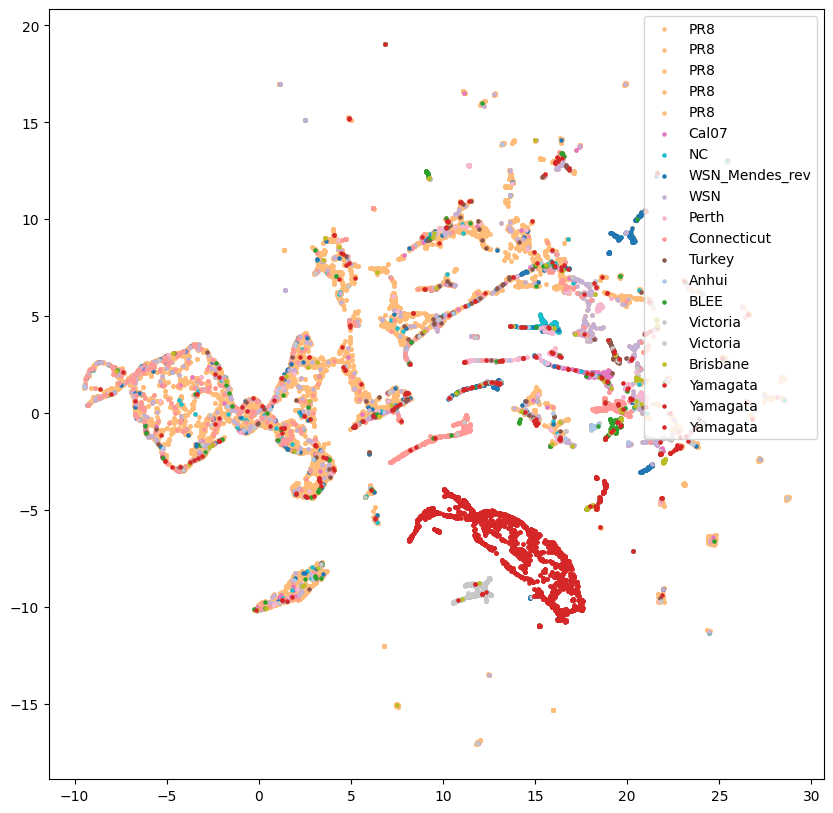

In [13]:
strains = list(set(DATASET_STRAIN_DICT.values()))

fig, ax = plt.subplots(figsize=(10, 10))
colors = [colormap(i/len(strains)) for i in range(len(strains))]

for i, (df, dfname) in enumerate(zip(dfs, dfnames)):
    keys = df["key"].to_list()
    t_df = umap_df[umap_df["keys"].isin(keys)]
    strain = DATASET_STRAIN_DICT[dfname]
    plt.scatter(t_df["UMAP1"], t_df["UMAP2"], label=strain, s=5, alpha=1, color=colors[strains.index(strain)])
    
plt.legend()
plt.show()

### check segment

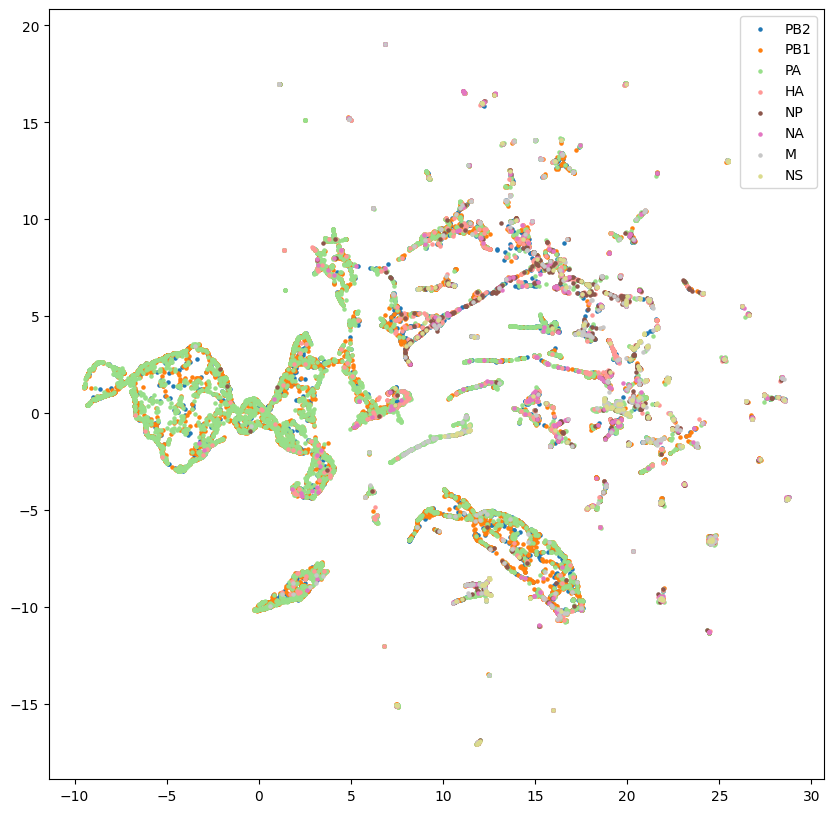

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = [colormap(i/len(SEGMENTS)) for i in range(len(SEGMENTS))]

for i, seg in enumerate(SEGMENTS):
    t_df = umap_df[umap_df["keys"].str.startswith(seg)]
    ax.scatter(t_df["UMAP1"], t_df["UMAP2"], label=seg, s=5, alpha=1, color=colors[i])
    
plt.legend()
plt.show()

### Create final figure (incl. highlighting)

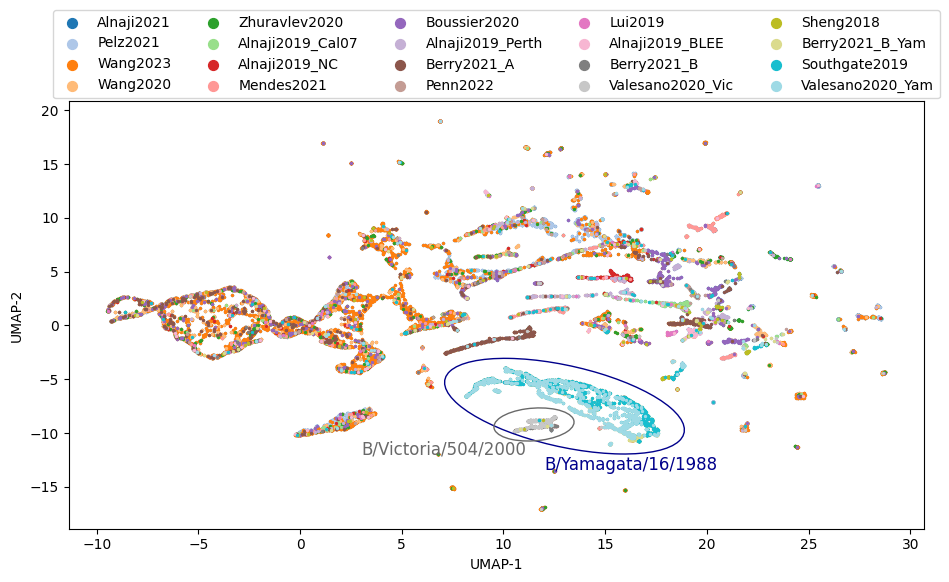

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = [colormap(i/20) for i in range(20)]

for i, (df, dfname) in enumerate(zip(dfs, dfnames)):
    keys = df["key"].to_list()
    t_df = umap_df[umap_df["keys"].isin(keys)]
    plt.scatter(t_df["UMAP1"], t_df["UMAP2"], label=dfname, s=2, alpha=1, color=colors[i])

color = "darkblue"
ellipse = Ellipse((13, -7.5), width=13, height=7, angle=-30, edgecolor=color, facecolor="none")
ax.add_patch(ellipse)
plt.text(12, -13.4, "B/Yamagata/16/1988", fontsize=12, color=color)

color = "dimgray"
ellipse = Ellipse((11.5, -9.2), width=4, height=3, angle=15, edgecolor=color, facecolor="none")
ax.add_patch(ellipse)
plt.text(3, -12, "B/Victoria/504/2000", fontsize=12, color=color)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.23), ncol=5, markerscale=5)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(os.path.dirname(RESULTSPATH), "additional_analyses", "batch_effect_supplement_A.png"), dpi=300)
plt.close()